# Import 

In [59]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import qutip as qt
from copy import deepcopy

import experiments as meas
from experiments.MM_dual_rail_base import MM_dual_rail_base
from fitting.fit_display_classes import GeneralFitting
from fitting.wigner import WignerAnalysis

from slab import AttrDict
from experiments import MultimodeStation, CharacterizationRunner, SweepRunner

from job_server import JobClient
from job_server.database import get_database
from job_server.config_versioning import ConfigVersionManager

# Initialize database and config manager
db = get_database()
config_dir = 'D:/python/multimode_expts/configs'
config_manager = ConfigVersionManager(config_dir)

# Initialize job client (handle submitting and waiting for jobs)
client = JobClient()

# Check server health
health = client.health_check()
print(f"Server status: {health['status']}")
print(f"Pending jobs: {health['pending_jobs']}")

user = "seb"
print("Welcome", user)


station = MultimodeStation(
    user=user,
    experiment_name = "250119_qec",
)

USE_QUEUE = True
mm_base_calib = MM_dual_rail_base(station.hardware_cfg, station.soc)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Server status: healthy
Pending jobs: 0
Welcome seb
[STATION] Using main hardware_config version: CFG-HW-20260122-00015
[STATION] Using main multiphoton_config version: CFG-MP-20260121-00001
[STATION] Using main man1_storage_swap version: CFG-M1-20260121-00001
[STATION] Using main floquet_storage_swap version: CFG-FL-20260121-00001
Data, plots, logs will be stored in: D:\experiments\250119_qec
Hardware configs will be read from D:\python\multimode_expts\configs\versions\hardware_config\CFG-HW-20260122-00015.yml
dict_keys(['Pyro.NameServer', 'Qick101'])
QICK running on ZCU216, software version 0.2.291

Firmware configuration (built Tue Oct 15 12:06:51 2024):

	Global clocks (MHz): tProcessor 430.080, RF reference 245.760

	7 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 32768 samples (5.128 us)
		fs=6389.760 MHz, fabric=399.360 MHz, 32-bit DDS, range=6389.760 MHz
		DAC tile 2, bl

In [60]:
# Define defaults, smart config preprocessing and post-measurement updates
# =====================================
singleshot_defaults = AttrDict(dict(    
    reps=5000,
    relax_delay=500,
    check_f=False,
    active_reset=False,
    man_reset=False,
    storage_reset=False,
    qubit=0,
    pulse_manipulate=False,
    cavity_freq=4984.373226159381,
    cavity_gain=400,
    cavity_length=2,
    prepulse=False,
    pre_sweep_pulse=None,
    gate_based=True,
    qubits=[0],
)) # Shouldn't be modifying this on the fly!
# You can use kwargs in the run function to override these values



def singleshot_postproc(station, expt):
    expt.analyze(plot=False, station=station, subdir=station.autocalib_path)
    fids = expt.data['fids']
    confusion_matrix = expt.data['confusion_matrix']
    thresholds_new = expt.data['thresholds']
    angle = expt.data['angle']
    print(fids)

    hardware_cfg = station.hardware_cfg
    hardware_cfg.device.readout.phase = [hardware_cfg.device.readout.phase[0] + angle]
    hardware_cfg.device.readout.threshold = thresholds_new
    hardware_cfg.device.readout.threshold_list = [thresholds_new]
    hardware_cfg.device.readout.Ie = [np.median(expt.data['Ie_rot'])]
    hardware_cfg.device.readout.Ig = [np.median(expt.data['Ig_rot'])]
    if expt.cfg.expt.active_reset:
        hardware_cfg.device.readout.confusion_matrix_with_active_reset = confusion_matrix
    else:
        hardware_cfg.device.readout.confusion_matrix_without_reset = confusion_matrix
    print('Updated readout!')

    expt.display(station)

Job submitted: JOB-20260122-00105 (queue position: 1)

[0.1s] Job JOB-20260122-00105: pending

[2.2s] Job JOB-20260122-00105: running
[WORKER] Loading HistogramExperiment from experiments.single_qubit.single_shot
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00105_HistogramExperiment.h5
[WORKER] Running experiment...
 66%|████████████████████████▏            | 3276/5000 [00:06<00:03, 498.95it/s]
[28.4s] Job JOB-20260122-00105: completed
100%|█████████████████████████████████████| 5000/5000 [00:10<00:00, 499.24it/s]
Unrotated:
Ig -108.3939393939394 +/- 28.399910611263785 	 Qg -13.066017316017316 +/- 23.255229016848233 	 Amp g 109.17860095201564
Ie 9.913419913419913 +/- 33.691548970249045 	 Qe -11.6504329004329 +/- 23.46167296076001 	 Amp e 15.297335753237551
Rotated:
Ig -108.5386641665502 +/- 28.399556550057426 	 Qg -11.798412149015896 +/- 23.25566139919318 	 Amp g 109.1780387637423
Ie 9.737420788669745 +/- 33.693795570605374 	 Qe -11.742579925747908 +/- 23.45

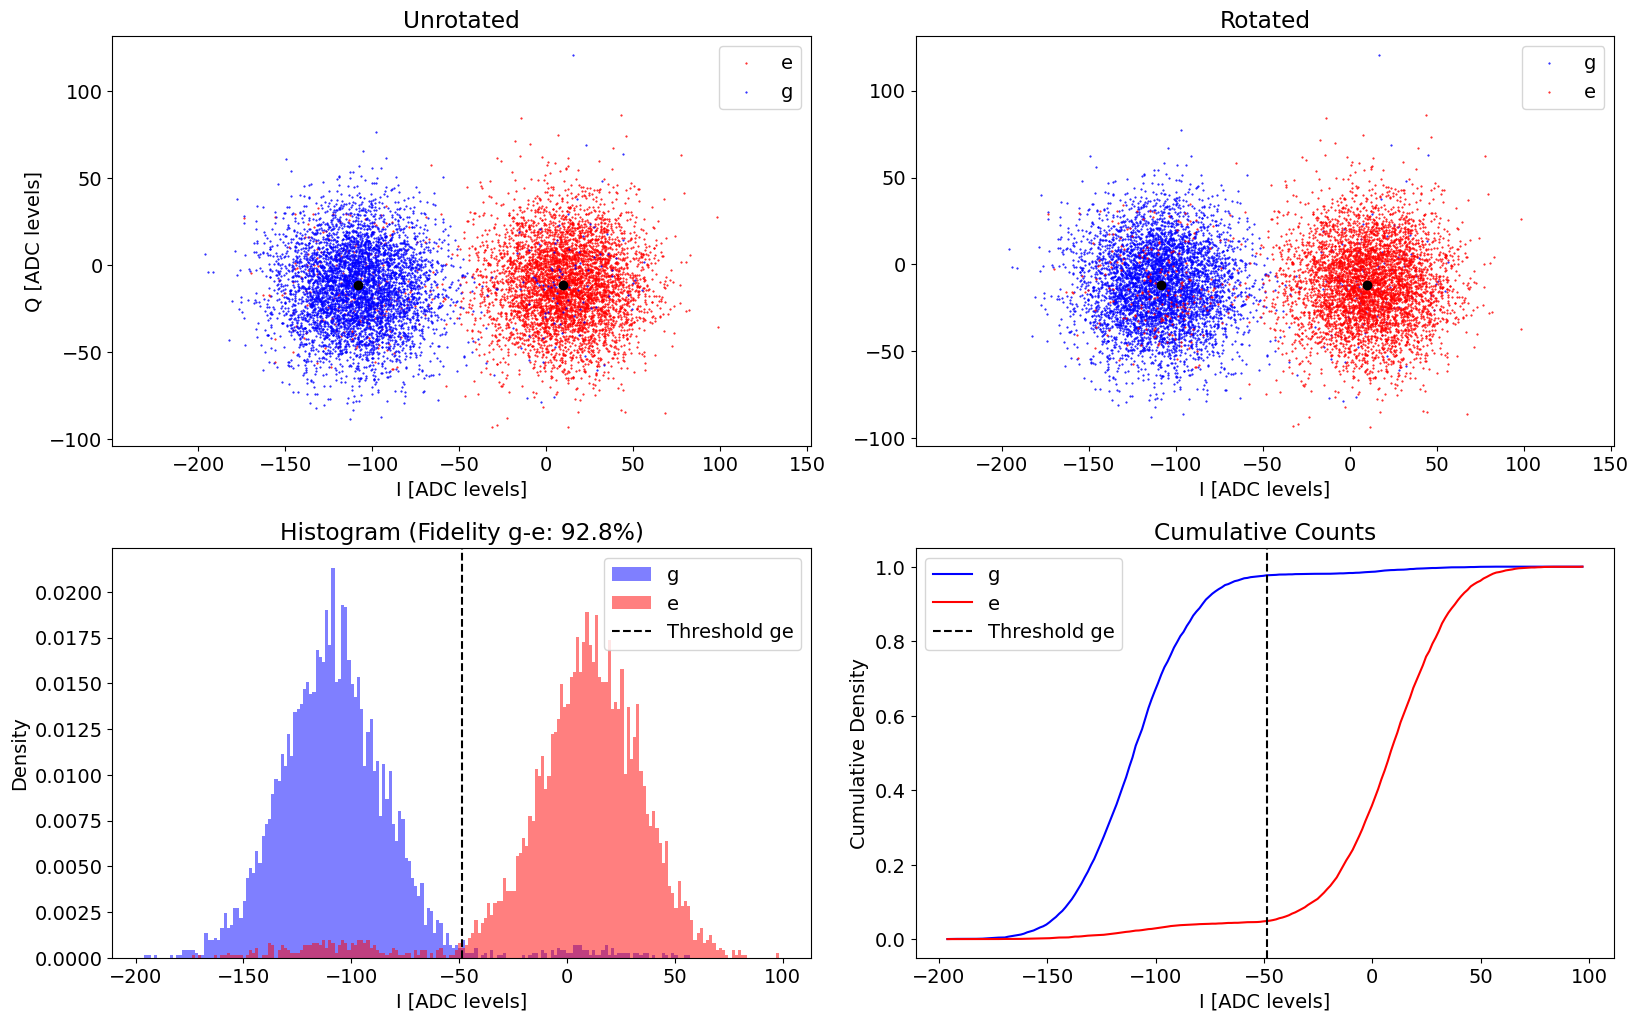

Plot saved to D:\experiments\250119_qec\plots\2026-01-22_16-08-13_histogram.png
Plot reference appended to D:\experiments\250119_qec\logs\2026-01-22.md
ge fidelity (%): 92.84000000000002
rotation angle (deg): -0.6855291395516608
threshold ge: -48.801027336732574


In [63]:
single_shot_runner = CharacterizationRunner(
    station = station,
    ExptClass = meas.HistogramExperiment,
    default_expt_cfg = singleshot_defaults,
    postprocessor = singleshot_postproc,
    job_client=client,
    use_queue=USE_QUEUE,
)

single_shot = single_shot_runner.execute(
        go_kwargs=dict(analyze=False, display=False),
        check_f=False,
        active_reset=False, # on recalibration of readout, turn off active reset because it will be wrong for selecting when to apply the qubit pulse
        relax_delay=2000,
        gate_based=False,
    )

In [88]:
expts_to_run = {
                #storage
                'stor_modes': [1], # [1,2, .., 7] if also want to run  all modes 
                }

qubit_start = 'g'
man_mode_no = 1


In [ ]:
# Helper function (kept from original)
def get_storage_mode_parameters(ds_storage, config_thisrun, man_mode_no, stor_mode_no):
    """Get pulse parameters for a given storage mode."""
    stor_name = 'M' + str(man_mode_no) + '-S' + str(stor_mode_no)
    freq = ds_storage.get_freq(stor_name)
    gain = ds_storage.get_gain(stor_name)
    pi_len = ds_storage.get_pi(stor_name)
    h_pi_len = ds_storage.get_h_pi(stor_name)
    flux_low_ch = config_thisrun.hw.soc.dacs.flux_low.ch
    flux_high_ch = config_thisrun.hw.soc.dacs.flux_high.ch
    ch = flux_low_ch if freq < 1000 else flux_high_ch

    mm_base_dummy = MM_dual_rail_base(config_thisrun, soccfg=station.soc)
    prep_man_pi = mm_base_dummy.prep_man_photon(man_mode_no)
    prepulse = mm_base_dummy.get_prepulse_creator(prep_man_pi).pulse.tolist()
    postpulse = mm_base_dummy.get_prepulse_creator(prep_man_pi[-1:-3:-1]).pulse.tolist()

    return freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse


# Configuration defaults for error amplification
error_amp_stor_defaults = AttrDict(dict(
    reps=50,
    rounds=1,
    qubit=0,
    qubits=[0],
    n_start=0,
    n_step=3,
    n_pulses=15,
    expts=50,
    active_reset=False,
    man_reset=True,
    storage_reset=True,
    relax_delay=2500,
    qubit_state_start='g',
))


def error_amp_stor_preproc(station, default_expt_cfg, man_mode_no=1, stor_mode_no=1, 
                           parameter_to_test='gain', span=None, start=None, **kwargs):
    """Preprocessor for error amplification storage."""
    expt_cfg = deepcopy(default_expt_cfg)
    expt_cfg.update(kwargs)
    
    stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    
    # Get current values
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )

    print('station len pi:', pi_len)




    if qubit_start == 'e':
        freq += station.hardware_cfg.device.manipulate.chi_ge[man_mode_no - 1]
    
    # Set pulse type for storage mode
    expt_cfg.pulse_type = ['storage', stor_name, 'pi', 0]
    expt_cfg.parameter_to_test = parameter_to_test
    
    # Set sweep range based on parameter
    if parameter_to_test == 'gain':
        if span is None:
            span = int(gain * 0.3)  # 30% of current gain
        if start is None:
            expt_cfg.start = int(gain - span / 2)

        expt_cfg.step = int(span / (expt_cfg.expts - 1))
    elif parameter_to_test == 'frequency':
        if span is None:
            span = 0.15  # MHz
        if start is None:
            expt_cfg.start = freq - span / 2
        expt_cfg.step = span / (expt_cfg.expts - 1)
    
    print(f'Error amp ({parameter_to_test}) for {stor_name}: center={freq if parameter_to_test=="frequency" else gain}, span={span}')
    
    return expt_cfg

# def error_amp_stor_postproc(station, expt, man_mode_no=1, stor_mode_no=1, parameter_to_test='gain'):
#     """Postprocessor for error amplification - updates gain or frequency."""
#     stor_name = f'M{man_mode_no}-S{stor_mode_no}'
    
    # Analyze with state_fin='e'
    # expt.analyze(state_fin='e')
    # expt.analyze(state_fin='e')
    # expt.display()
    
    # Update the appropriate parameter
    # optimal_value = expt.data['fit_avgi'][2]
    
    # if parameter_to_test == 'gain':
    #     station.ds_storage.update_gain(stor_name, int(optimal_value))
    #     print(f'Updated gain for {stor_name}: {int(optimal_value)}')
    # if parameter_to_test == 'frequency':
    #     station.ds_storage.update_freq(stor_name, optimal_value)
    #     print(f'Updated frequency for {stor_name}: {optimal_value:.4f} MHz')

# Create runner (we'll pass parameter_to_test at runtime)
# error_amp_stor_runner = CharacterizationRunner(
#     station=station,
#     ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
#     default_expt_cfg=error_amp_stor_defaults,
#     preprocessor=error_amp_stor_preproc,
#     # postprocessor=error_amp_stor_postproc,
#     job_client=client,
#     use_queue=USE_QUEUE,
# )

In [112]:
# for each storage mode, we will each over the length and for each point we will optimize frequency, then gain and finally frequency again, hence we need for each storage mode to store the length vector tohether with the frequency and gain vectors
length_vectors = {}
gain_vectors = {}
freq_vectors = {}
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    freq, gain, pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )
    len_min = (pi_len * 0.3)
    len_max = (pi_len * 1.2)
    print(f"Storage mode {stor_mode_no}:")
    print(f"  pi_len = {pi_len} us, optimizing from {len_min} us to {len_max} us")
    length_vectors[stor_mode_no] = np.linspace(len_max, len_min, num=2)
    gain_vectors[stor_mode_no] = np.linspace(gain, gain, num=5) # placeholder for now 
    freq_vectors[stor_mode_no] = np.linspace(freq, freq, num=5) # placeholder for now

Storage mode 1:
  pi_len = 2.1151597581422275 us, optimizing from 0.6345479274426682 us to 2.5381917097706728 us


2.5381917097706728
Running error amp (frequency) for M1-S1
Testing pi length: 2.5381917097706728 us, gain: 3405.0, frequency: 352.80916881056754 MHz
station len pi: 2.5381917097706728
Error amp (frequency) for M1-S1: center=352.80916881056754, span=0.2
Job submitted: JOB-20260122-00129 (queue position: 1)

[0.1s] Job JOB-20260122-00129: pending

[2.1s] Job JOB-20260122-00129: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00129_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'g', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'parameter_to_test': 'frequency', 'start': 352.70

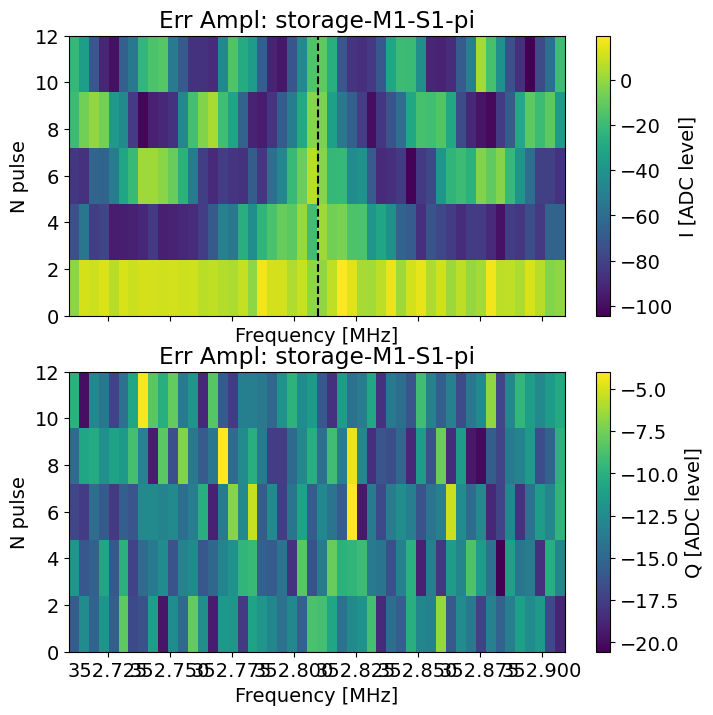

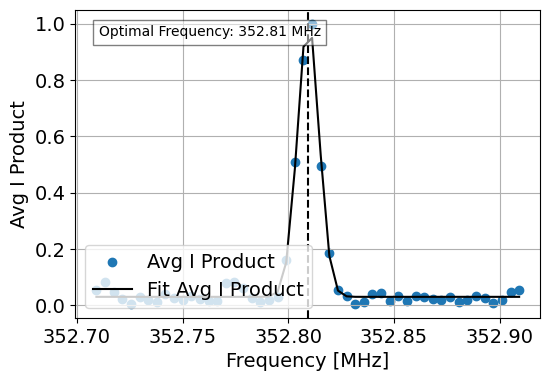

Updated frequency for M1-S1: 352.8094 MHz
Running error amp (gain) for M1-S1
station len pi: 2.5381917097706728
Error amp (gain) for M1-S1: center=3405, span=1021
Job submitted: JOB-20260122-00130 (queue position: 1)

[0.1s] Job JOB-20260122-00130: pending

[2.1s] Job JOB-20260122-00130: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00130_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'g', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'parameter_to_test': 'gain', 'start': 2894, 'step': 20}
n_pts [ 0  3  6  9 12]
  0%|                                                    | 0

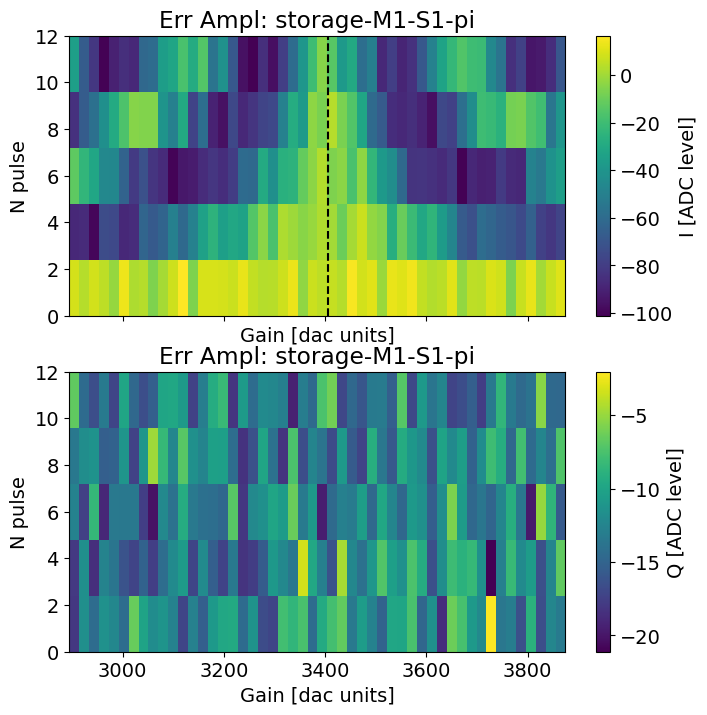

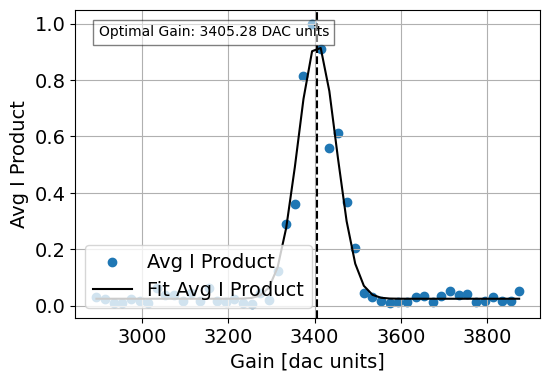

Updated gain for M1-S1: 3405
0.6345479274426682
Running error amp (frequency) for M1-S1
Testing pi length: 0.6345479274426682 us, gain: 3405.2844163880577, frequency: 352.80939024815444 MHz
station len pi: 0.6345479274426682
Error amp (frequency) for M1-S1: center=352.80939024815444, span=0.2
Job submitted: JOB-20260122-00131 (queue position: 1)

[0.1s] Job JOB-20260122-00131: pending

[2.1s] Job JOB-20260122-00131: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00131_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'g', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'paramet

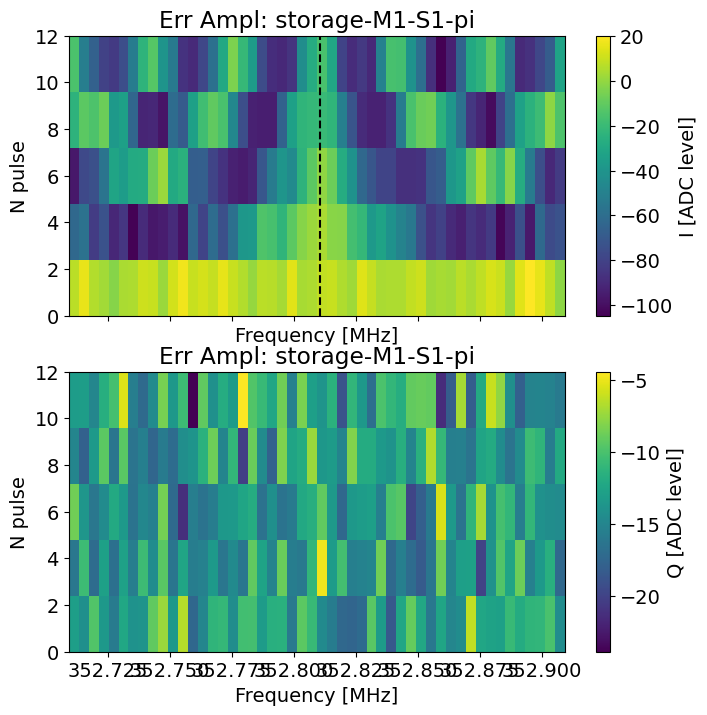

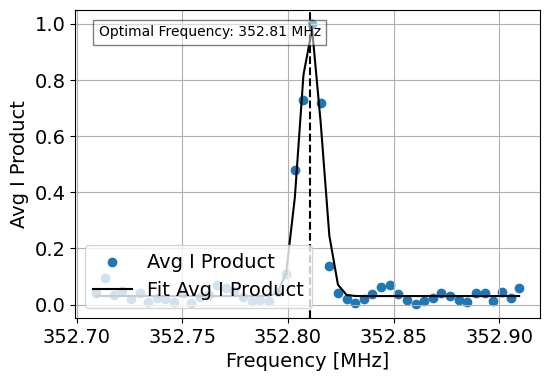

Updated frequency for M1-S1: 352.8106 MHz
Running error amp (gain) for M1-S1
station len pi: 0.6345479274426682
Error amp (gain) for M1-S1: center=3405, span=1021
Job submitted: JOB-20260122-00132 (queue position: 1)

[0.1s] Job JOB-20260122-00132: pending

[2.3s] Job JOB-20260122-00132: running
[WORKER] Loading ErrorAmplificationExperiment from experiments.single_qubit.error_amplification
[WORKER] Creating experiment instance
[WORKER]   Data file: JOB-20260122-00132_ErrorAmplificationExperiment.h5
[WORKER] Running experiment...
cfg at start of acquire {'reps': 50, 'rounds': 1, 'qubit': 0, 'qubits': [0], 'n_start': 0, 'n_step': 3, 'n_pulses': 10, 'expts': 50, 'active_reset': False, 'man_reset': True, 'storage_reset': True, 'relax_delay': 2500, 'qubit_state_start': 'g', 'analyze': False, 'display': False, 'pulse_type': ['storage', 'M1-S1', 'pi', 0], 'parameter_to_test': 'gain', 'start': 2894, 'step': 20}
n_pts [ 0  3  6  9 12]
  0%|                                                    | 0

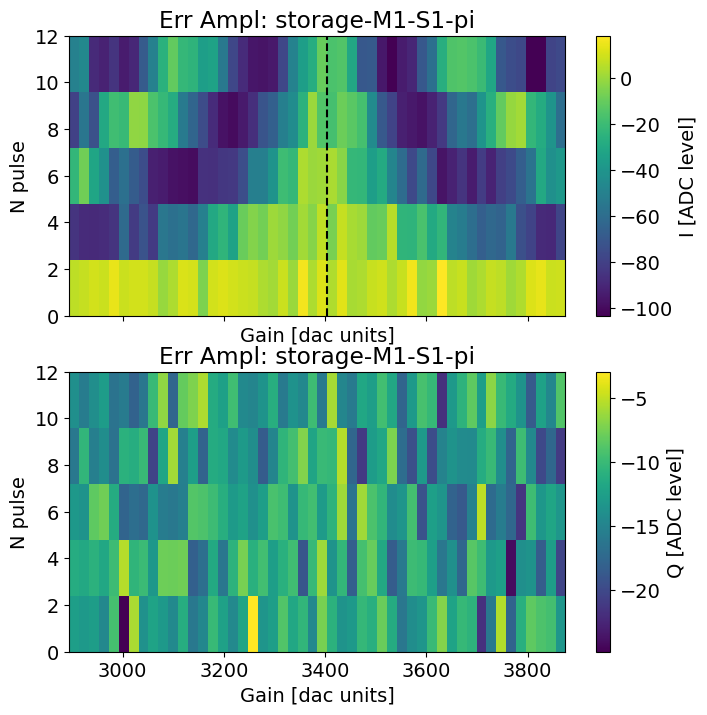

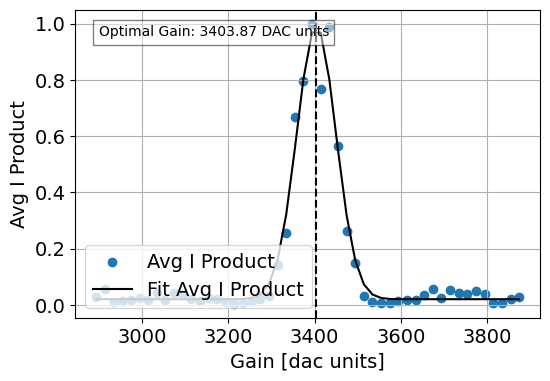

Updated gain for M1-S1: 3403


In [113]:
# Error Amplification Storage - New Pattern with CharacterizationRunner


# Example execution - gain optimization followed by frequency optimization
for stor_mode_no in expts_to_run.get('stor_modes', [1]):
    stor_name = f'M1-S{stor_mode_no}'

    original_freq, original_gain, original_pi_len, h_pi_len, ch, prepulse, postpulse = get_storage_mode_parameters(
        station.ds_storage, station.hardware_cfg, man_mode_no, stor_mode_no
    )

    # set the pi_length, gain and frequency to be tested
    for idx, pi_len_test in enumerate(length_vectors[stor_mode_no]):
        station.ds_storage.update_pi(stor_name, pi_len_test)
        _idx = idx if idx==0 else idx-1
        station.ds_storage.update_gain(stor_name, gain_vectors[stor_mode_no][_idx])  
        station.ds_storage.update_freq(stor_name, freq_vectors[stor_mode_no][_idx]) 

        print(station.ds_storage.get_pi(stor_name)) 

        print(f'Running error amp (frequency) for {stor_name}')
        print(f"Testing pi length: {pi_len_test} us, gain: {gain_vectors[stor_mode_no][_idx]}, frequency: {freq_vectors[stor_mode_no][_idx]} MHz")
        # Round 1: Frequency optimization

        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_freq = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='frequency',
            span=0.2,
            n_step=3,
            n_pulses=10,
            analyze=False,
            display=False,
            reps=50,
            qubit_state_start=qubit_start,
        )

        # update frequency based on optimization

        error_amp_freq.analyze(state_fin='e')
        error_amp_freq.display()
        optimal_value_freq = error_amp_freq.data['fit_avgi'][2]
        freq_vectors[stor_mode_no][idx] = optimal_value_freq
        station.ds_storage.update_freq(stor_name, optimal_value_freq)
        print(f'Updated frequency for {stor_name}: {optimal_value_freq:.4f} MHz')

        # Round 2: Gain optimization
        print(f'Running error amp (gain) for {stor_name}')
        error_amp_stor_runner = CharacterizationRunner(
            station=station,
            ExptClass=meas.single_qubit.error_amplification.ErrorAmplificationExperiment,
            default_expt_cfg=error_amp_stor_defaults,
            preprocessor=error_amp_stor_preproc,
            # postprocessor=error_amp_stor_postproc,
            job_client=client,
            use_queue=USE_QUEUE,
        )
        error_amp_gain = error_amp_stor_runner.execute(
            man_mode_no=man_mode_no,
            stor_mode_no=stor_mode_no,
            parameter_to_test='gain',
            span=int(original_gain * 0.3),
            n_step=3,
            n_pulses=10,
            analyze=False,
            display=False,
            reps=50,
            qubit_state_start=qubit_start,
        )

        # update gain based on optimization
        error_amp_gain.analyze(state_fin='e')
        error_amp_gain.display()
        optimal_value_gain = error_amp_gain.data['fit_avgi'][2]
        gain_vectors[stor_mode_no][idx] = optimal_value_gain
        station.ds_storage.update_gain(stor_name, int(optimal_value_gain))
        print(f'Updated gain for {stor_name}: {int(optimal_value_gain)}')



    
    # restore original parameters after length sweep
    station.ds_storage.update_pi(stor_name, original_pi_len)
    station.ds_storage.update_gain(stor_name, original_gain)
    station.ds_storage.update_freq(stor_name, original_freq)
        



In [105]:
station.ds_storage.df['pi (mus)'][0]

1.7626331317851895